# CSI 4810 - Project 2 - Text Mining Reddit Posts
##### Willow Connelly

---

I Could find most frequently occuring words and display

I could also use similarity to trim down the word subset? or maybe just lemmaizing

I could find most unique words (not necessarily most frequent) and display

I could find most common topics

I could then group those topics into clusters where each dot is a title. I could also weight them by the upvotes.


In [ ]:
# TODO: wordcloud ngram tuning/duplicate removal
# TODO: tune topic sentence structure and run on large dataset
# TODO: (opt) Integrate upvotes as weights

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import praw
from wordcloud import WordCloud
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from collections import Counter
pd.set_option('display.max_colwidth', None)


In [ ]:
reddit = praw.Reddit(
    client_id="5DEFxmbu1nIVbteepOjXdw",
    client_secret="phSKbMc45hNevM3m-u8U5opnCg3pcg",
    user_agent="CSI4810_p2 version 1 by /u/Worldly_Turnip1077",
)

print(reddit.read_only)
# data = []
# for submission in reddit.subreddit("politics").top(limit=500,time_filter="month"):
#     data.append(submission)
#     print(submission.title)

# with open("reddit_submissions.pkl", "wb") as f:
#     pickle.dump(data, f)

True


In [6]:
with open("reddit_submissions.pkl", "rb") as f:
    data = pickle.load(f)

In [9]:
# could weight with upvote ratio and/or score and/or number of comments
for d in data:
    print(d.upvote_ratio, d.score, d.url)
    # print(d.title)

0.86 50784 https://www.usnews.com/opinion/articles/2024-11-18/forget-matt-gaetz-merrick-garland-is-americas-worst-attorney-general
0.95 49240 https://www.cnbc.com/2024/11/21/trump-ag-pick-matt-gaetz-says-hes-withdrawing.html
0.85 46512 https://newrepublic.com/post/188492/stock-market-tanks-trump-cabinet
0.9 43267 https://www.washingtonexaminer.com/news/3232941/trump-national-emergency-mass-deportation-program/
0.93 36447 https://www.ibtimes.com/trump-accidentally-helps-dems-get-key-judicial-nominees-approved-taking-republicans-watch-spacex-3751915
0.95 35878 https://azmirror.com/briefs/biden-locks-in-6-6b-for-huge-tsmc-chip-factories-in-arizona-ensuring-trump-cant-rescind-chips-act-deal/
0.87 32436 https://www.huffpost.com/entry/photo-rfk-jr-mcdonalds-coke-trump_n_673a27d8e4b0520a46775887
0.92 31266 https://www.axios.com/2024/11/19/trump-dr-oz-cms-cabinet
0.95 28543 https://www.thebulwark.com/p/merrick-garland-must-release-jack-smith-final-report
0.66 28015 https://www.newsweek.com/gle

In [ ]:
titles = []
for d in data:
    titles.append(d.title.lower())
print(titles)

500


In [9]:
nlp = spacy.load('en_core_web_sm')
docs = list(nlp.pipe(titles))

displacy.render(docs, style='ent' )

c:\Users\willo_jlqcl0r\miniconda3\envs\textMining\Lib\site-packages\spacy\displacy\__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [97]:
for doc in docs:
    print("----"*20)
    for s in doc:
        if(s.is_alpha and not s.is_stop):
            print(s.text,s.pos_,s.dep_)

--------------------------------------------------------------------------------
high ADJ amod
school NOUN compound
student NOUN attr
witnesses NOUN attr
fight NOUN nsubj
release VERB acl
damning VERB amod
house NOUN compound
ethics NOUN compound
report NOUN dobj
allegations NOUN pobj
matt PROPN compound
gaetz PROPN nmod
donald PROPN compound
trump PROPN nmod
pick NOUN nsubj
attorney NOUN compound
general NOUN pobj
sex NOUN dobj
year NOUN npadvmod
old ADJ amod
girl NOUN nsubj
begun VERB ROOT
--------------------------------------------------------------------------------
elon PROPN compound
musk PROPN poss
ai NOUN nsubj
turns VERB ROOT
labels VERB conj
significant ADJ amod
spreaders NOUN pobj
misinformation NOUN pobj
x NOUN pobj
--------------------------------------------------------------------------------
husband NOUN nsubj
family NOUN conj
voted VERB ccomp
trump NOUN pobj
canceling VERB ROOT
thanksgiving PROPN dobj
christmas PROPN conj
----------------------------------------------

In [10]:
# could set the NER using .set_ents()
combinedDocs = spacy.tokens.Doc.from_docs(docs)
combinedDocs

“she was a high school student and there were witnesses.” - the fight to release a damning house ethics report about allegations that matt gaetz—donald trump’s pick for attorney general—had sex with a 17-year-old girl has begun. elon musk's ai turns on him, labels him 'one of the most significant spreaders of misinformation on x' my husband and his family voted for trump — so i'm canceling thanksgiving and christmas voters punished biden for problems he didn’t cause and effectively addressed bernie sanders doubles down that people are ‘angry’ with dems after pelosi said she didn’t ‘respect’ his remarks matt gaetz just resigned from congress, ending a probe into sexual misconduct and drug use stock market tanks as trump unveils nightmare cabinet picks wait... what? folks in red states google searched 'how to change my vote' in droves after trump's victory donald trump got away with everything donald trump jr mocks president zelensky saying ukraine’s ‘allowance is about to run out’ trump

In [ ]:
# Tokenization, POS tagging, lemmatization
print(list(combinedDocs.noun_chunks))

for s in docs:
    for token in s:
        if(token.pos_ == "NOUN" or token.pos_ == "PROPN"):
            print(f"Token: {token.text}, POS: {token.pos_}, Lemma: {token.lemma_}, Dependency: {token.dep_}")
        # print(f"Entity: {ent.text}, Label: {ent.label_}")


[she, a high school student, witnesses, the fight, a damning house ethics report, allegations, matt gaetz—donald trump’s pick, attorney general, sex, a 17-year-old girl, elon musk's ai, him, him, the most significant spreaders, misinformation, x, my husband, his family, trump, i, thanksgiving, christmas, voters, biden, problems, he, bernie sanders, people, dems, pelosi, she, his remarks, matt gaetz, congress, a probe, sexual misconduct, drug use, stock market tanks, trump unveils, cabinet picks, what, folks, red states, google, my vote, droves, trump's victory, donald trump, everything, donald trump jr mocks president, zelensky, ukraine’s ‘allowance, trump, chilling joke, power, forever - donald trump, the two-term limit, maga, project, the agenda, pentagon, trump's nomination, fox news host, defense secretary, trump, ethics agreement, presidential transition, trump’s pick, u.s. military, tattoos, white supremacists, nazis, trump appoints project, 2025 co, -, border czar, democrats, wa

---

### Term frequency

In [12]:
print(combinedDocs)

“she was a high school student and there were witnesses.” - the fight to release a damning house ethics report about allegations that matt gaetz—donald trump’s pick for attorney general—had sex with a 17-year-old girl has begun. elon musk's ai turns on him, labels him 'one of the most significant spreaders of misinformation on x' my husband and his family voted for trump — so i'm canceling thanksgiving and christmas voters punished biden for problems he didn’t cause and effectively addressed bernie sanders doubles down that people are ‘angry’ with dems after pelosi said she didn’t ‘respect’ his remarks matt gaetz just resigned from congress, ending a probe into sexual misconduct and drug use stock market tanks as trump unveils nightmare cabinet picks wait... what? folks in red states google searched 'how to change my vote' in droves after trump's victory donald trump got away with everything donald trump jr mocks president zelensky saying ukraine’s ‘allowance is about to run out’ trump

In [ ]:
words_to_exclude = {"sanders"}
cleaned_docs = []

for doc in docs:
    l = []
    for token in doc:
        if (token.is_alpha and not token.is_stop):
            l.append(token.lemma_ if token.text not in words_to_exclude else token.text)
    print(l)
    cleaned_docs.append(l)

print(cleaned_docs)

['high', 'school', 'student', 'witness', 'fight', 'release', 'damn', 'house', 'ethic', 'report', 'allegation', 'matt', 'gaetz', 'donald', 'trump', 'pick', 'attorney', 'general', 'sex', 'year', 'old', 'girl', 'begin']
['elon', 'musk', 'ai', 'turn', 'label', 'significant', 'spreader', 'misinformation', 'x']
['husband', 'family', 'vote', 'trump', 'cancel', 'thanksgiving', 'christmas']
['voter', 'punish', 'biden', 'problem', 'cause', 'effectively', 'address']
['bernie', 'sanders', 'double', 'people', 'angry', 'dem', 'pelosi', 'say', 'respect', 'remark']
['matt', 'gaetz', 'resign', 'congress', 'end', 'probe', 'sexual', 'misconduct', 'drug', 'use']
['stock', 'market', 'tank', 'trump', 'unveil', 'nightmare', 'cabinet', 'pick']
['wait', 'folk', 'red', 'states', 'google', 'search', 'change', 'vote', 'drove', 'trump', 'victory']
['donald', 'trump', 'get', 'away']
['donald', 'trump', 'jr', 'mocks', 'president', 'zelensky', 'say', 'ukraine', 'allowance', 'run']
['trump', 'make', 'chilling', 'joke'

In [14]:
vectorizer = CountVectorizer(stop_words='english',binary=False,ngram_range=(1,3)).fit( [' '.join(tokens) for tokens in cleaned_docs]) 

print(f"Number of terms selected: {len(vectorizer.vocabulary_)}\n")

transformed= vectorizer.transform([' '.join(tokens) for tokens in cleaned_docs]).toarray()
word_freq = pd.DataFrame(transformed.sum(axis=0).reshape(1,len(vectorizer.vocabulary_)),columns=vectorizer.get_feature_names_out())

print("Most frequent words:\n", word_freq.iloc[0].nlargest(3))

Number of terms selected: 436

Most frequent words:
 trump           14
donald           5
donald trump     5
Name: 0, dtype: int64


In [15]:
print(word_freq.iloc[0].to_dict())
# Could retokenize specific words
# Could remove words if they are already in a higher rated n-gram

{'address': 1, 'agency': 1, 'agency possibly': 1, 'agency possibly forever': 1, 'agenda': 1, 'agreement': 1, 'agreement require': 1, 'agreement require presidential': 1, 'ai': 1, 'ai turn': 1, 'ai turn label': 1, 'allegation': 1, 'allegation matt': 1, 'allegation matt gaetz': 1, 'allowance': 1, 'allowance run': 1, 'angry': 1, 'angry dem': 1, 'angry dem pelosi': 1, 'appoint': 1, 'appoint project': 1, 'appoint project author': 1, 'attorney': 2, 'attorney general': 2, 'attorney general matt': 1, 'attorney general sex': 1, 'author': 1, 'author border': 1, 'author border czar': 1, 'away': 1, 'bad': 2, 'bad donald': 1, 'bad donald trump': 1, 'bad think': 1, 'bad think attorney': 1, 'begin': 1, 'bernie': 1, 'bernie sanders': 1, 'bernie sanders double': 1, 'biden': 1, 'biden problem': 1, 'biden problem cause': 1, 'bolton': 1, 'bolton fbi': 1, 'bolton fbi investigation': 1, 'border': 1, 'border czar': 1, 'cabinet': 1, 'cabinet pick': 1, 'cancel': 1, 'cancel thanksgiving': 1, 'cancel thanksgivin

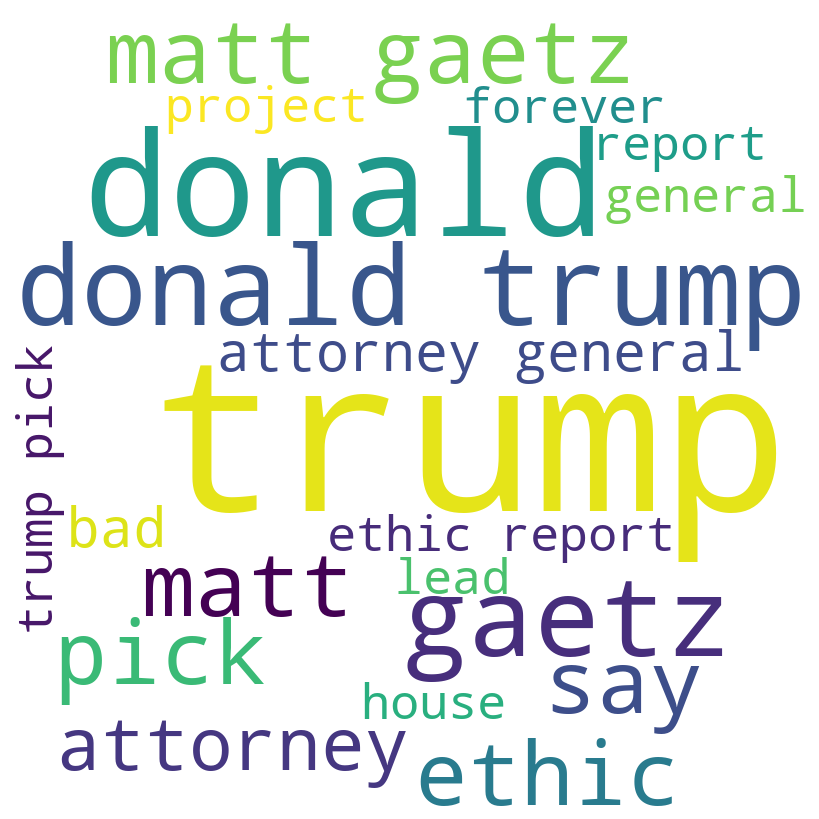

In [15]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(word_freq.iloc[0].nlargest(20).to_dict())

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

---

Util Functions

In [ ]:
def createDataStruct(clusterNumber):
    ds = {}
    for i in range(clusterNumber):
        ds[i] = {'verb':[],
                 'obj':[],
                 'topic':[]}
    return ds

def extractTopics(clusterNumber,docClusterList):
    topicList = createDataStruct(clusterNumber)
    
    for i,doc in enumerate(docs):
        cluster = docClusterList[i]
        if cluster == -1: continue
        for token in doc:
            if(token.is_alpha and not token.is_stop):
                if(token.dep_ == 'ROOT'):
                    topicList[cluster]['verb'].append(token.lemma_)
                if(token.dep_ == 'dobj' or token.dep_ == 'nmod'):
                    topicList[cluster]['obj'].append(token.lemma_ if token not in words_to_exclude else token)

    # print(topicList)
    for key,val in topicList.items():
        val['topic'].extend([Counter(val['verb']).most_common(1)[0][0],Counter(val['obj']).most_common(2)])
        # print(val['topic'])
    return topicList

---
### Topic Detection - tf-idf NMF

In [21]:
print(cleaned_docs)

[['high', 'school', 'student', 'witness', 'fight', 'release', 'damn', 'house', 'ethic', 'report', 'allegation', 'matt', 'gaetz', 'donald', 'trump', 'pick', 'attorney', 'general', 'sex', 'year', 'old', 'girl', 'begin'], ['elon', 'musk', 'ai', 'turn', 'label', 'significant', 'spreader', 'misinformation', 'x'], ['husband', 'family', 'vote', 'trump', 'cancel', 'thanksgiving', 'christmas'], ['voter', 'punish', 'biden', 'problem', 'cause', 'effectively', 'address'], ['bernie', 'sanders', 'double', 'people', 'angry', 'dem', 'pelosi', 'say', 'respect', 'remark'], ['matt', 'gaetz', 'resign', 'congress', 'end', 'probe', 'sexual', 'misconduct', 'drug', 'use'], ['stock', 'market', 'tank', 'trump', 'unveil', 'nightmare', 'cabinet', 'pick'], ['wait', 'folk', 'red', 'states', 'google', 'search', 'change', 'vote', 'drove', 'trump', 'victory'], ['donald', 'trump', 'get', 'away'], ['donald', 'trump', 'jr', 'mocks', 'president', 'zelensky', 'say', 'ukraine', 'allowance', 'run'], ['trump', 'make', 'chilli

In [16]:
from sklearn.decomposition import NMF
from  sklearn.feature_extraction.text import TfidfVectorizer

tvect = TfidfVectorizer(stop_words='english')
tfidf = tvect.fit_transform([' '.join(tokens) for tokens in cleaned_docs])

nmf = NMF(beta_loss="kullback-leibler",solver="mu",n_components=5)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("w",W.shape,"\nh",H.shape)

w (20, 5) 
h (5, 143)


In [ ]:
ws = tvect.get_feature_names_out()

topwords=[]
for i,topic in enumerate(H):
    topwords.append(pd.DataFrame(H,columns = ws).iloc[i].nlargest(10).index)

topdoc=[]
for doc in enumerate(W):
    topdoc.append(doc[1].argmax())
topwords

[Index(['donald', 'trump', 'away', 'forever', 'bad', 'deliver', 'republicans',
        'trifecta', 'win', 'house'],
       dtype='object'),
 Index(['gaetz', 'report', 'ethic', 'matt', 'bolton', 'confirmation', 'fbi',
        'gabbard', 'investigation', 'democrats'],
       dtype='object'),
 Index(['project', 'say', 'agenda', 'maga', 'appoint', 'author', 'border',
        'czar', 'angry', 'bernie'],
       dtype='object'),
 Index(['vote', 'trump', 'agreement', 'presidential', 'require', 'sign',
        'transition', 'cancel', 'christmas', 'family'],
       dtype='object'),
 Index(['pick', 'cabinet', 'market', 'nightmare', 'stock', 'tank', 'unveil',
        'address', 'biden', 'cause'],
       dtype='object')]

In [177]:
tfidfTopics = extractTopics(W.shape[1],topdoc)
tfidfTopics = pd.DataFrame([(x,y['topic']) for x,y in tfidfTopics.items()],columns=['topic_number','topic_desc'])

In [181]:
topicDocMatrix = pd.concat([pd.DataFrame(titles,columns=["title"]),pd.DataFrame(topdoc,columns=["topic_number"])],
                           axis=1).join(tfidfTopics['topic_desc'], on='topic_number')
topicDocMatrix

,title,topic_number,topic_desc
0,“she was a high school student and there were witnesses.” - the fight to release a damning house ethics report about allegations that matt gaetz—donald trump’s pick for attorney general—had sex with a 17-year-old girl has begun.,1,"[begin, [(report, 1), (gaetz, 1)]]"
1,"elon musk's ai turns on him, labels him 'one of the most significant spreaders of misinformation on x'",4,"[turn, [(biden, 1), (pick, 1)]]"
2,my husband and his family voted for trump — so i'm canceling thanksgiving and christmas,3,"[cancel, [(thanksgiving, 1), (vote, 1)]]"
3,voters punished biden for problems he didn’t cause and effectively addressed,4,"[turn, [(biden, 1), (pick, 1)]]"
4,bernie sanders doubles down that people are ‘angry’ with dems after pelosi said she didn’t ‘respect’ his remarks,2,"[double, [(respect, 1), (remark, 1)]]"
5,"matt gaetz just resigned from congress, ending a probe into sexual misconduct and drug use",1,"[begin, [(report, 1), (gaetz, 1)]]"
6,stock market tanks as trump unveils nightmare cabinet picks,4,"[turn, [(biden, 1), (pick, 1)]]"
7,wait... what? folks in red states google searched 'how to change my vote' in droves after trump's victory,3,"[cancel, [(thanksgiving, 1), (vote, 1)]]"
8,donald trump got away with everything,0,"[get, [(trump, 2), (house, 1)]]"
9,donald trump jr mocks president zelensky saying ukraine’s ‘allowance is about to run out’,0,"[get, [(trump, 2), (house, 1)]]"


---

### Topic Detection - sentence embeddings & clustering

In [ ]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(titles)
embeddings

array([[-0.00790585,  0.06834525,  0.05079865, ...,  0.0021544 ,
         0.01126797,  0.00051283],
       [ 0.02472559,  0.04596113, -0.01868397, ..., -0.00362072,
        -0.0053595 , -0.01073412],
       [-0.07253691,  0.08698313, -0.03317272, ...,  0.00978838,
        -0.010555  , -0.0364684 ],
       ...,
       [-0.0306568 ,  0.07462484, -0.0184956 , ...,  0.02798891,
        -0.01479884, -0.06001624],
       [-0.01716759,  0.07995733,  0.04487773, ..., -0.02956091,
        -0.01346247,  0.01100918],
       [ 0.03224664,  0.07740783,  0.03207738, ...,  0.04857061,
        -0.07527098, -0.02775719]], dtype=float32)

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = pd.DataFrame(cosine_similarity(embeddings))

In [24]:
from sklearn.cluster import HDBSCAN

hdbs = HDBSCAN(min_cluster_size=2,metric='precomputed',cluster_selection_epsilon=.5)
hdbsClusters = hdbs.fit(1-similarities)

In [189]:
hdbsClusters.labels_ ,hdbsClusters.probabilities_

(array([ 3, -1,  0, -1, -1,  3, -1, -1,  4,  1,  1,  2,  2,  4,  2,  2,  3,
         0,  3,  3]),
 array([1.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 1.        ,
        1.        , 1.        , 0.63085938, 1.        , 0.63192962,
        1.        , 0.98060984, 1.        , 0.94742285, 0.8835441 ]))

In [224]:
hdbscanTopics = extractTopics(hdbsClusters.labels_.max()+1,hdbsClusters.labels_)

In [221]:
hdbscanTopics = pd.DataFrame([(x,y['topic']) for x,y in hdbscanTopics.items()],columns=['topic_number','topic_desc'])
print(hdbscanTopics)
hdbsTopicDocMatrix = pd.concat([pd.DataFrame(titles,columns=["title"]),pd.DataFrame(hdbsClusters.labels_ ,columns=["topic_number"])],
                           axis=1).join(hdbscanTopics['topic_desc'], on='topic_number')
hdbsTopicDocMatrix

   topic_number                                 topic_desc
0             0  [cancel, [(thanksgiving, 1), (house, 1)]]
1             1                        [say, [(trump, 1)]]
2             2        [say, [(military, 1), (tattoo, 1)]]
3             3         [begin, [(trump, 2), (report, 1)]]
4             4                    [get, [(agreement, 1)]]


,title,topic_number,topic_desc
0,“she was a high school student and there were witnesses.” - the fight to release a damning house ethics report about allegations that matt gaetz—donald trump’s pick for attorney general—had sex with a 17-year-old girl has begun.,3,"[begin, [(trump, 2), (report, 1)]]"
1,"elon musk's ai turns on him, labels him 'one of the most significant spreaders of misinformation on x'",-1,NaN
2,my husband and his family voted for trump — so i'm canceling thanksgiving and christmas,0,"[cancel, [(thanksgiving, 1), (house, 1)]]"
3,voters punished biden for problems he didn’t cause and effectively addressed,-1,NaN
4,bernie sanders doubles down that people are ‘angry’ with dems after pelosi said she didn’t ‘respect’ his remarks,-1,NaN
5,"matt gaetz just resigned from congress, ending a probe into sexual misconduct and drug use",3,"[begin, [(trump, 2), (report, 1)]]"
6,stock market tanks as trump unveils nightmare cabinet picks,-1,NaN
7,wait... what? folks in red states google searched 'how to change my vote' in droves after trump's victory,-1,NaN
8,donald trump got away with everything,4,"[get, [(agreement, 1)]]"
9,donald trump jr mocks president zelensky saying ukraine’s ‘allowance is about to run out’,1,"[say, [(trump, 1)]]"


In [222]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=3)
Xtsne = tsne.fit_transform(similarities)

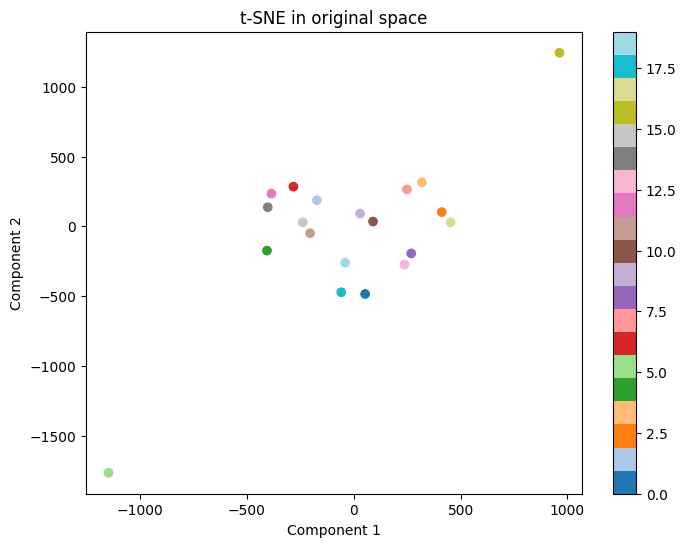

In [223]:
plt.figure(figsize=(8, 6))
plt.scatter(Xtsne[:, 0], Xtsne[:, 1], c=range(0,20), cmap='tab20')
plt.colorbar()
plt.title('t-SNE in original space')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

---